# CV project

## import libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import contours
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Softmax, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from skimage.metrics import structural_similarity as ssim
from keras.preprocessing import image
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from keras.preprocessing import image
from tensorflow import keras
from PIL import ImageOps
from keras import backend as K

In [ ]:
img_shape=(256, 64, 1)
alphabets=u"۰۱۲۳۴۵۶۷۸۹"
num_of_characters = len(alphabets) + 1
max_str_len=16

In [ ]:
def preprocess_train(data, shape=(256,64)):

    img = preprocess(data)
    img = img/255
    return np.array(img).reshape(shape[0], shape[1], 1)

def label_to_num(label,alphabets=u"۰۱۲۳۴۵۶۷۸۹"):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num,alphabets=u"۰۱۲۳۴۵۶۷۸۹"):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

def preprocess_image(img):
  return np.array(img.resize((256,64)).convert('L'))

## functions

In [ ]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [ ]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype('int').tolist()

def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)

def scan(img):
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)

    orig_img = img.copy()
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)

    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]


    if len(page) == 0:
        return orig_img
    for c in page:
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        if len(corners) == 4:
            break
    corners = sorted(np.concatenate(corners).tolist())
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    h, w = orig_img.shape[:2]
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return cv2.resize(final, (600, 400))

In [ ]:
def is_credit_card(img):
  temp = cv2.imread('/content/template.jpg')
  res = cv2.matchTemplate(img, temp, cv2.TM_CCOEFF_NORMED)
  if np.any(res >= 0.6):
    return True
  return False

## Part a - Pretrain code

In [ ]:
def generate_numbers():
  # Define the size and number of images
  image_size = (28, 28)
  num_images = 100000

  # Generate random images of handwritten digits
  images = []
  labels = []
  for _ in range(num_images):
      # Generate a blank canvas for the digit
      image = np.zeros(image_size, dtype=np.uint8)

      # Randomly select a digit (0 to 9)
      digit = np.random.randint(0, 10)

      # Randomly select font and scale for the digit
      font = np.random.randint(0, 8)
      scale = np.random.uniform(0.5, 0.8)

      # Randomly select position to place the digit
      x = np.random.randint(2, 10)
      y = np.random.randint(18, 24)

      # Draw the digit on the canvas
      cv2.putText(image, str(digit), (x, y), font, scale, (255), 1, cv2.LINE_AA)
      ret, image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
      images.append(image)
      labels.append(digit)

  # Convert the images and labels to arrays
  images = np.array(images)
  labels = np.array(labels)

  # fig, axs = plt.subplots(2, 5, figsize=(10, 4))
  # for i, ax in enumerate(axs.flat):
  #     ax.imshow(x[i], cmap='gray')
  #     ax.set_title(str(y[i]))
  #     ax.axis('off')
  # plt.tight_layout()
  # plt.show()

  x_train = images[:int(num_images * 0.6)]
  y_train = labels[:int(num_images * 0.6)]
  x_val = images[int(num_images * 0.6) : int(num_images * 0.8)]
  y_val = labels[int(num_images * 0.6) : int(num_images * 0.8)]
  x_test = images[int(num_images * 0.8):]
  y_test = labels[int(num_images * 0.8):]
  return (x_train, y_train, x_val, y_val, x_test, y_test)


In [ ]:
# get the data
x_train, y_train, x_val, y_val, x_test, y_test = generate_numbers()

In [ ]:
#normalization
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_val = x_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
english_number_model = keras.Sequential()

english_number_model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
english_number_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
english_number_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
english_number_model.add(keras.layers.Dropout(0.25))

english_number_model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
english_number_model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
english_number_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
english_number_model.add(keras.layers.Dropout(0.25))

english_number_model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
english_number_model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
english_number_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
english_number_model.add(keras.layers.Dropout(0.25))

english_number_model.add(keras.layers.Flatten())
english_number_model.add(keras.layers.Dense(512, activation='relu'))
english_number_model.add(keras.layers.Dropout(0.5))
english_number_model.add(keras.layers.Dense(10, activation='softmax'))

english_number_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                        

In [ ]:
english_number_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
english_number_model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
469/469 [==============================] - 20s 15ms/step - loss: 0.5711 - accuracy: 0.7876 - val_loss: 0.0302 - val_accuracy: 0.9917
Epoch 2/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0537 - accuracy: 0.9832 - val_loss: 0.0075 - val_accuracy: 0.9981
Epoch 3/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0312 - accuracy: 0.9906 - val_loss: 0.0041 - val_accuracy: 0.9984
Epoch 4/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0173 - accuracy: 0.9947 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.0018 - val_accuracy: 0.9994


In [ ]:
score = english_number_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0016773721436038613
Test accuracy: 0.9994999766349792


In [ ]:
!unzip /content/digit_templates.zip

Archive:  /content/digit_templates.zip
   creating: digit_templates/
  inflating: digit_templates/0.png   
  inflating: digit_templates/1.png   
  inflating: digit_templates/2.png   
  inflating: digit_templates/3.png   
  inflating: digit_templates/4.png   
  inflating: digit_templates/5.png   
  inflating: digit_templates/6.png   
  inflating: digit_templates/7.png   
  inflating: digit_templates/8.png   
  inflating: digit_templates/9.png   


In [ ]:
from numpy.ma.core import zeros
def predict_digit_via_model(img):
  img = np.resize(img, (28, 28))
  img = img.reshape((1, 28, 28))
  y = english_number_model.predict(img)
  return np.argmax(y)

def get_digit_templates():
  digits = []
  for i in range(10):
    img = cv2.imread('/content/digit_templates/' + str(i) + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    digits.append(cv2.resize(img, (150, 200)))
  return np.array(digits)


def predict_digit_via_template(img):
  img = cv2.resize(img, (150, 200))
  digit_temps = get_digit_templates()
  scores = []
  for d in range(10):
    res = cv2.matchTemplate(img, digit_temps[d], cv2.TM_CCOEFF_NORMED)
    (_, score, _, _) = cv2.minMaxLoc(res)
    scores.append(score)
  return np.argmax(scores)


## part b - predict images

In [ ]:
def get_credit_card_number(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  black_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (12, 8)))
  # imshow(balck_hat)
  gradX = cv2.Sobel(black_hat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
  gradX = np.absolute(gradX)
  (minVal, maxVal) = (np.min(gradX), np.max(gradX))
  gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
  gradX = gradX.astype("uint8")
  # imshow(gradX)
  gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (12, 8)))
  thresh = cv2.threshold(gradX, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
  # imshow(thresh)
  cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  locs = []

  # imgCopy = img.copy()

  # #draw contours
  # cv2.drawContours(imgCopy, cnts, -1, (0, 255, 0), 4)
  # imshow(imgCopy)

  ################################################################

  # imgCopy = img.copy()
  for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    if ar > 2.5 and ar < 4.0:
      # print(w, h, ar)
      # cv2.rectangle(imgCopy, (x, y), (x + w, y + h), (255, 0, 0), 3)
      if (w > 75) and (h >= 25):
        locs.append((x, y, w, h))

  # for l in locs:
  #   (x, y, w, h) = l
  #   cv2.rectangle(imgCopy, (x, y), (x + w, y + h), (255, 255, 0), 3)
  # imshow(imgCopy)

  #######################################################

  locs = sorted(locs, key=lambda x:x[0])
  output = []

  res = ""
  for (i, (gX, gY, gW, gH)) in enumerate(locs):

    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, group = cv2.threshold(group, 127, 255, cv2.THRESH_BINARY_INV)
    # imshow(group)

    digitCnts, hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

    # print(len(digitCnts))
    for c in digitCnts:
      (x, y, w, h) = cv2.boundingRect(c)
      # print(x, y, w, h)
      roi = group[max(y - 2, 0):y + h + 2, max(x - 2, 0):x + w + 2]

      #predict with template matching
      if w > 10 and h > 10:
        res += str(predict_digit_via_template(roi))
    res += " "
  return res

6274 1212 0036 1145 


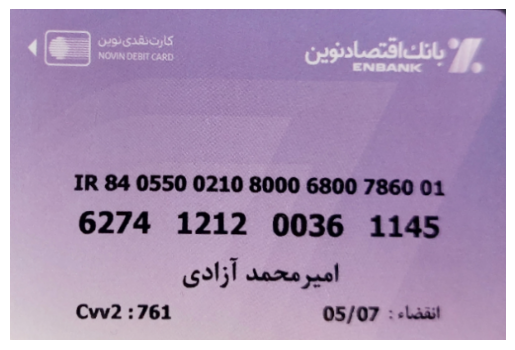

In [ ]:
img = cv2.imread('/content/card1.jpg')
img = scan(img)
# print(img.shape, img.shape[1] / float(img.shape[0]))
imshow(img)
print(get_credit_card_number(img))

In [ ]:
def predict(model,images):
  y_pred = model.predict(images)
  number = ""
  for i in range(len(images)):
    sample_lbl = np.argmax(y_pred[i])
    number += str(sample_lbl)
  return number

In [ ]:
f = scan(cv2.imread('/content/example.jpg'))
imshow(f)

In [ ]:
def get_contours(img, alpha = (30,20), beta=(5,5)):

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  balck_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, alpha))
  # imshow(balck_hat)
  gradX = cv2.Sobel(balck_hat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
  gradX = np.absolute(gradX)
  (minVal, maxVal) = (np.min(gradX), np.max(gradX))
  gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
  gradX = gradX.astype("uint8")
  # imshow(gradX)
  gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, alpha))
  thresh = cv2.threshold(gradX, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  # apply a second closing operation to the binary image, again
  # to help close gaps between credit card number regions
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, beta))
  # imshow(thresh)
  cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  return cnts


def get_national_id_area(contours):

  contour_areas = [cv2.boundingRect(c) for c in contours]
  width_height_div = [w/h for (x, y, w, h) in contour_areas]
  max_contour_area_id = np.argmax(width_height_div)

  national_id_candidates = []

  for (x, y, w, h) in contour_areas:
      if w/h >= int(max(width_height_div)) -1:
          national_id_candidates.append((x, y, w, h))

  national_id_areas_params = national_id_candidates[0]

  for candidate in national_id_candidates:
      if candidate[1] < national_id_areas_params[1]:
        national_id_areas_params = candidate

  return national_id_areas_params


contours = get_contours(f)

x, y, w, h = get_national_id_area(contours)

print(x, y, w, h)
# locs = []

imgCopy = f.copy()

#draw contours
print(len(contours))
cv2.drawContours(imgCopy, contours[:], -1, (0, 255, 0), 4)
imshow(imgCopy)

# for i, c in enumerate(contours):
#     print(i)
#     print(cv2.contourArea(c))
#     (x, y, w, h) = cv2.boundingRect(c)
#     print(w/h)
#     print(x, y)
#     print('*'*5)

cropped_img = f.copy()[y - 40:y + h + 10, x - 60:x + w + 30]
print(f.shape)
imshow(cropped_img)


In [ ]:
import cv2
import numpy as np

img = cropped_img.copy()
# converting to LAB color space
lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel
# feel free to try different values for the limit and grid size:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Stacking the original image with the enhanced image
result = np.hstack((img, enhanced_img))
imshow(result)

In [ ]:
import cv2
import numpy as np

img = cropped_img.copy()
# converting to LAB color space
lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel
# feel free to try different values for the limit and grid size:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Stacking the original image with the enhanced image
result = np.hstack((img, enhanced_img))
imshow(result)

In [ ]:
def load_model_national_id(path='/content/drive/MyDrive/model_new_national_card.h5'):
    return keras.models.load_model('/content/drive/MyDrive/model_new_national_card.h5', compile=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def predict_national_id_digits(img):
    pass

model = load_model_national_id()

# resized = cv2.resize(cropped_img, (256,64), interpolation = cv2.INTER_AREA)
# imshow(resized)
# balck_hat = cv2.morphologyEx(cropped_img, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (12, 8)))
# imshow(balck_hat)

# # example_image = cv2.imread('/content/drive/MyDrive/DataSet/new_national_card/۹۱۲۳۳۴۶۸۴۳.jpg')
# # example_image.shape
# # cropped_img.shape
# example = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
# ret,thresh = cv2.threshold(example, 130, 255, cv2.THRESH_BINARY)
resized_img = cv2.resize(cropped_img, (256, 64), interpolation = cv2.INTER_AREA)
# imshow(resized_img)
img = preprocess_train(cropped_img)

plt.figure(figsize=(5, 10))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    image = img
    plt.imshow(image[:,:,0])

    # image = preprocess(image)
    # image = image/255.
    pred = model.predict(img.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0][:10]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)